In [70]:
import numpy as np 
import pandas as pd
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt
import seaborn as sns

### Project Background

I have gathered data spanning several NHL seasons with the aim of trying to cluster individual NHL players into their respective positions, given game-by-game statistics for each player. There are four possible positions a player can assume; **Right Wing (RW)**, **Left Wing (LW)**, **Centerman (C)**, or **Defenseman (D)**. For the sake of this analysis I am excluding goalies, as it would be fairly trivial to predict which player's are goalies based on their game statistics. 

Data statistics included but are not limited to the time player spent on the ice per game, shots taken per game, faceoffs taken per game, and the player's height. I will build two different clustering models with `k=4` clusters, and evaluate model performance based on the homogeneity of each model cluster.

I have gathered data from [Kagggle](https://www.kaggle.com/datasets/martinellis/nhl-game-data?datasetId=56652&sortBy=dateRun&tab=profile&select=game_skater_stats.csv) for this analysis. I will leverage two datasets durign this ananlysis; one dataset containing game-by-game statistics for each player and another containing the player's primary position. I will use the player's actual primary position from the second dataset in order to evaluate my models. 

This notebook and analysis can be found on my Github in [this repository](https://github.com/elutins/MSDS_DTSA/tree/main/5510)

In [71]:
# will merge df-player-info onto df_skaters to get the actual position of the player
df_skaters = pd.read_csv("/kaggle/input/nhl-game-data/game_skater_stats.csv")
df_player_info = pd.read_csv("/kaggle/input/nhl-game-data/player_info.csv")
df_games = pd.read_csv("/kaggle/input/nhl-game-data/game.csv")
df_plays = pd.read_csv("/kaggle/input/nhl-game-data/game_plays.csv")

In [72]:
# also bringing over the players height and weight to use as input features for the model
df_skaters = df_skaters.merge(df_player_info[['player_id',  'height_cm', 'weight', 'primaryPosition', 'firstName', 'lastName']], on="player_id", how='left')
df_skaters = df_skaters.merge(df_games[['game_id', 'date_time_GMT']], on="game_id", how='left')

df_skaters.info(show_counts=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130682 entries, 0 to 1130681
Data columns (total 28 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   game_id               1130682 non-null  int64  
 1   player_id             1130682 non-null  int64  
 2   team_id               1130682 non-null  int64  
 3   timeOnIce             1130682 non-null  int64  
 4   assists               1130682 non-null  int64  
 5   goals                 1130682 non-null  int64  
 6   shots                 1130682 non-null  int64  
 7   hits                  732575 non-null   float64
 8   powerPlayGoals        1130682 non-null  int64  
 9   powerPlayAssists      1130682 non-null  int64  
 10  penaltyMinutes        1130682 non-null  int64  
 11  faceOffWins           1130682 non-null  int64  
 12  faceoffTaken          1130682 non-null  int64  
 13  takeaways             732575 non-null   float64
 14  giveaways             732575 non-n

In [92]:
df_skaters.sample(4)

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,height_cm,weight,primaryPosition,firstName,lastName,date_time_GMT
125672,2015020232,8475247,15,553,0,0,1,2.0,0,0,5,6,9,0.0,0.0,0,0,0.0,0,553,0,0,182.88,207.0,C,Michael,Latta,2015-11-13T00:00:00Z
121175,2016020538,8476458,2,966,0,0,3,1.0,0,0,2,3,12,2.0,0.0,0,0,0.0,-2,816,0,150,185.42,194.0,C,Ryan,Strome,2016-12-30T01:00:00Z
358197,2009020549,8470018,7,561,0,0,1,NaN,0,0,0,7,8,NaN,NaN,0,0,NaN,0,561,0,0,182.88,208.0,LW,Matt,Ellis,2009-12-24T00:00:00Z
774178,2019020095,8475163,22,695,0,0,0,0.0,0,0,0,0,0,0.0,1.0,0,0,0.0,1,695,0,0,193.04,208.0,RW,Alex,Chiasson,2019-10-17T01:30:00Z


## Exploratory Data Analysis


Each model will use the following input features
- time on ice
- goals
- assists
- shots
- hits
- penalty minutes
- faceoffs taken
- takeaways
- giveaways
- blocked shots
- player height
- player weight

In [93]:
# it appears all fields from player info were successfully merged into df_skaters (no null values for those fields in dataset)
df_skaters.sample(4)

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,height_cm,weight,primaryPosition,firstName,lastName,date_time_GMT
904748,2019021000,8478233,20,1163,0,1,3,1.0,0,0,0,0,1,0.0,0.0,0,0,1.0,0,1137,0,26,177.80,184.0,LW,Andrew,Mangiapane,2020-02-29T21:00:00Z
908757,2019021027,8477425,1,951,0,0,3,1.0,0,0,0,0,0,0.0,0.0,0,0,0.0,-2,804,0,147,187.96,195.0,LW,Miles,Wood,2020-03-04T03:00:00Z
910290,2019021034,8478133,8,793,0,0,4,0.0,0,0,0,3,4,0.0,0.0,0,0,0.0,-1,573,0,220,185.42,181.0,C,Jake,Evans,2020-03-06T00:00:00Z
453462,2007020002,8468635,24,1149,0,1,4,NaN,0,0,0,0,0,NaN,NaN,0,0,NaN,1,986,155,8,187.96,215.0,LW,Travis,Moen,2007-09-30T16:00:00Z


In [73]:
features = [
    "timeOnIce",
    "assists",
    "goals",
    "shots",
    "hits",
    "penaltyMinutes",
    "faceoffTaken",
    "takeaways",
    "giveaways",
    "blocked",
]
response = ["primaryPosition"]

In [74]:
# seeing the date range for which this dataset has games over
df_skaters['date_time_GMT'] = pd.to_datetime(df_skaters['date_time_GMT'], utc=True) # forcing pandas to convert dates to UTC
min_date = min(df_skaters['date_time_GMT'])
max_date = max(df_skaters['date_time_GMT'])

print(f"this dataset contains games played from {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")

this dataset contains games played from 2000-10-04 to 2020-09-29


#### Step 1: aggregating players stats 

Need to aggregate player stats on a per game average basis (eg: time on ice per game, shots per game, etc). I will use a filtered version of this aggregated dataset as my model trainin data

In [75]:
# need to keep in player_id to group on in below steps
df = df_skaters[["player_id"] + features + response]

df.isnull().mean()

player_id          0.000000
timeOnIce          0.000000
assists            0.000000
goals              0.000000
shots              0.000000
hits               0.352095
penaltyMinutes     0.000000
faceoffTaken       0.000000
takeaways          0.352095
giveaways          0.352095
blocked            0.352095
primaryPosition    0.000000
dtype: float64

In [106]:
# in order to aggregate properly, the dataset currently contains NaN values in certain feature fields.
# These NaNs represent field values in which the player did not record any of that particular statistic over the course of the game.
# Therefore all Null values can be filled with 0s for our use case
df[features] = df[features].fillna(0)

# assuring that the above code worked properly
assert sum(df.isnull().sum()) == 0, "there are still null values in dataset"

In [77]:
# aggregating stats
agg_mapping = {feature: np.sum for feature in features}
agg_mapping['primaryPosition'] = np.size # arbitrarily using position to get size here. could work for any non-null field though

df_agg = df.groupby(['player_id']).agg(agg_mapping).reset_index()
df_agg = df_agg.rename(columns={'primaryPosition': 'games_played'})

df_agg.sample(4)

,player_id,timeOnIce,assists,goals,shots,hits,penaltyMinutes,faceoffTaken,takeaways,giveaways,blocked,games_played
2702,8476915,449710,88,48,657,1235.0,394,1247,185.0,290.0,306.0,603
215,8456760,289049,77,29,360,0.0,78,3776,0.0,0.0,0.0,281
2482,8475980,6089,0,0,7,24.0,0,27,1.0,2.0,2.0,12
2475,8475907,495812,161,117,1157,1644.0,525,379,287.0,305.0,183.0,639


In [78]:
# merging back the players actual position
df_agg = df_agg.merge(df_player_info[['player_id', 'primaryPosition', 'firstName', 'lastName']], on="player_id", how='left')

# converting time on ice from seconds to minutes to be slightly more understandable
df_agg['timeOnIce'] = np.round(df_agg['timeOnIce'] / 60, 2)

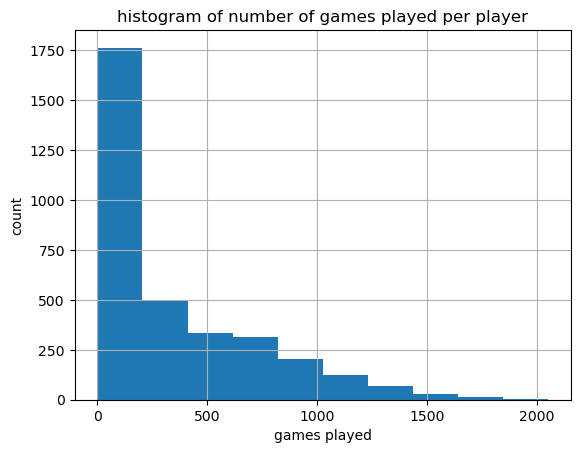

count    3353.000000
mean      337.215031
std       382.390368
min         1.000000
5%          2.000000
10%         5.000000
15%        10.000000
25%        29.000000
50%       179.000000
max      2050.000000
Name: games_played, dtype: float64

In [14]:
# seeing distribution of how many games each player has played in this dataset. may want to filter only to players who have played a certain number of games
df_agg.hist("games_played")
plt.title("histogram of number of games played per player")
plt.xlabel("games played")
plt.ylabel("count")
plt.show()

df_agg.games_played.describe(percentiles=[.05, .1, .15, .25])

In [79]:
# only considering players who played in more than 10 games total - which is the 15th percentile of the games_played field
threshold = df_agg['games_played'].quantile(q=.15)
df_agg = df_agg[df_agg.games_played > threshold].reset_index(drop=True)

In [80]:
# calculating feature per game avgs
for feat in features:
    df_agg[f"avg_{feat}"] = np.round(df_agg[feat] / df_agg['games_played'], 3)
    
df_agg.sample(4)

,player_id,timeOnIce,assists,goals,shots,hits,penaltyMinutes,faceoffTaken,takeaways,giveaways,blocked,games_played,primaryPosition,firstName,lastName,avg_timeOnIce,avg_assists,avg_goals,avg_shots,avg_hits,avg_penaltyMinutes,avg_faceoffTaken,avg_takeaways,avg_giveaways,avg_blocked
1417,8471222,10716.48,60,12,365,765.0,472,0,76.0,181.0,676.0,583,D,Ladislav,Smid,18.382,0.103,0.021,0.626,1.312,0.810,0.000,0.13,0.31,1.16
627,8464964,1267.77,6,2,73,0.0,145,1,0.0,0.0,0.0,82,D,Dan,Focht,15.461,0.073,0.024,0.890,0.000,1.768,0.012,0.00,0.00,0.00
657,8465041,2360.47,24,11,264,0.0,91,1272,0.0,0.0,0.0,222,C,Craig,MacDonald,10.633,0.108,0.050,1.189,0.000,0.410,5.730,0.00,0.00,0.00
648,8465016,1621.02,14,7,123,0.0,628,9,0.0,0.0,0.0,281,RW,Scott,Parker,5.769,0.050,0.025,0.438,0.000,2.235,0.032,0.00,0.00,0.00


#### Step 2: Look at feature distributions and correlations

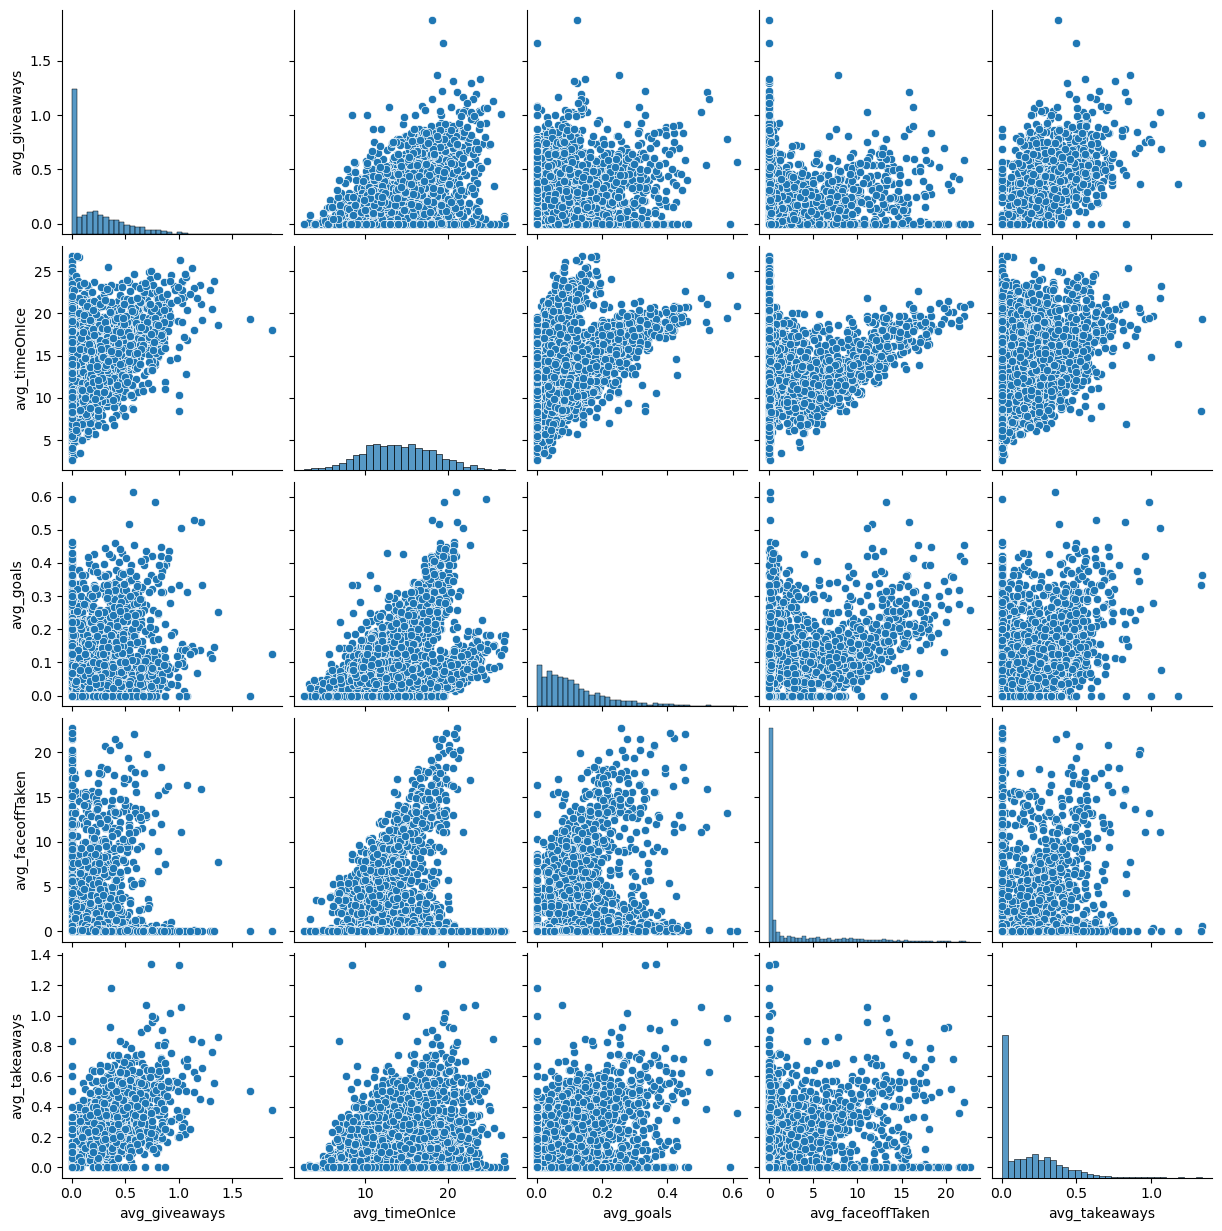

In [17]:
features = [f"avg_{f}" for f in features]

plot1_features = np.random.choice(features, size=len(features)//2, replace=False)
sns.pairplot(df_agg[plot1_features])
plt.show()

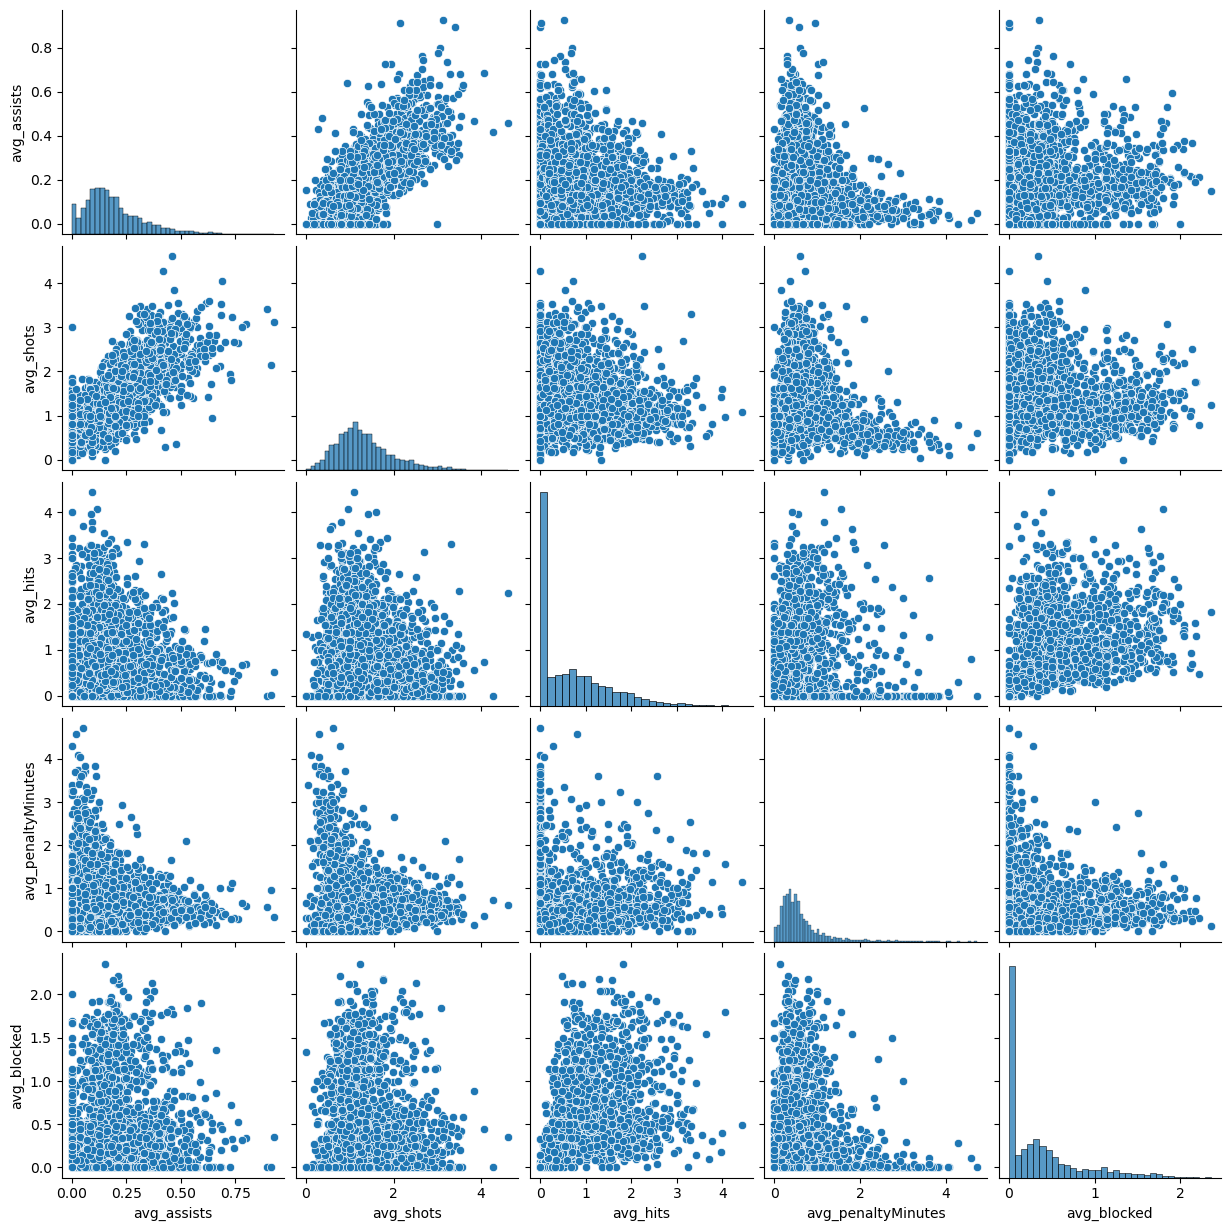

In [18]:
plot2_features = [f for f in features if f not in plot1_features]
sns.pairplot(df_agg[plot2_features])
plt.show()

My hypothesis is that `timeOnIce`, `shots` `faceoffs taken`, and `goals` are all going to be important features for clustering players into a respective position. I will not look at box plots of each feature, broken out by actual position, to get a sense of how well these features naturally separate players already

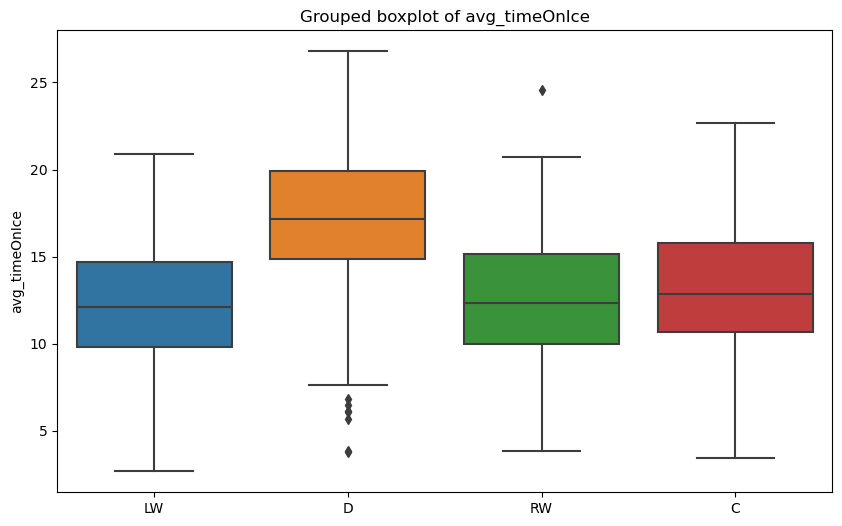

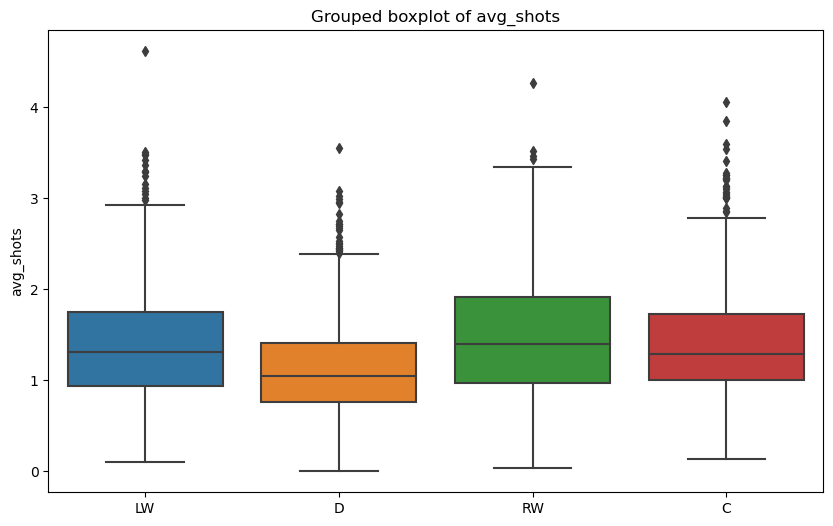

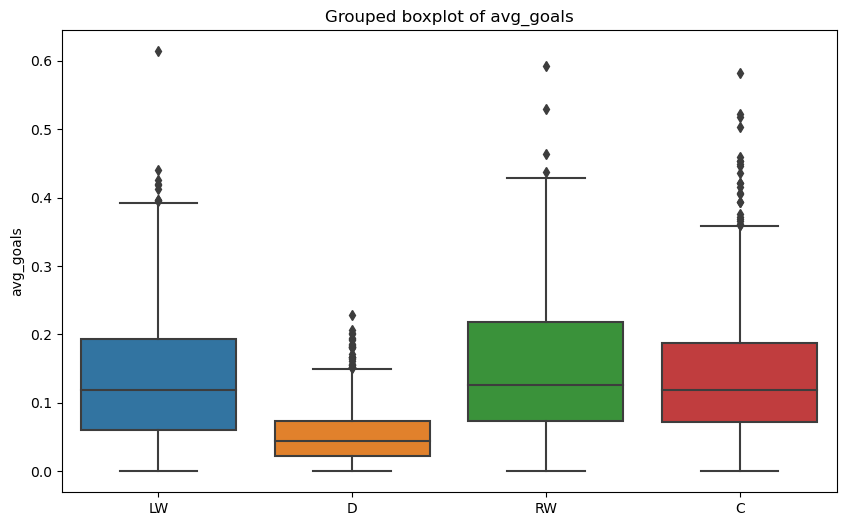

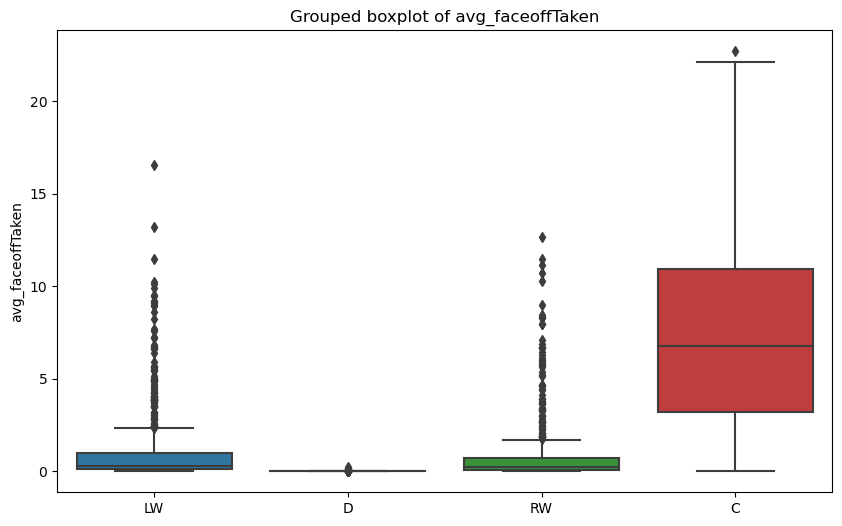

In [19]:
possible_important_feats = ['avg_timeOnIce', 'avg_shots', 'avg_goals', 'avg_faceoffTaken']

for f in possible_important_feats:
    plt.figure(figsize=(10, 6))
    sns.boxplot(df_agg, y=f, x="primaryPosition")
    plt.title(f"Grouped boxplot of {f}")
    plt.xlabel("")
    plt.show()

**We can see from the above boxplot that `timeOnIce` does a decent job at separating out Defensemen from the rest of the positions. `faceoffsTaken` does a great job at separating out Centermen from the rest of the positions, and `goals` does a good job at splitting offensive players (C, RW, LW) from defensemen.**

*It is also worth noting that the above boxplots unveil outliers in the dataset for specific fields. I am choosing not to remove specific field outliers because, in this case, I feel outliers may actually assist the model in learning the proper clusters. I am also not removing records where there are outliers for the number of `gamesa_played` since we took the player's averages on a per game basis*

## Modeling



### Model 1: KNN Clustering

For the first clustering model I will build a K-Nearest Neighbors based model. I will use `k=4` throughout the models, but will hypertune the `algorithm` and `metric` parameters in order to yield the best model

In [25]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# because clustering methods do not output class labels because they are unsupervised by nature, we need to manually assign the model output to specific labels
# depending on which output label --> actual class label yields the highest accuracy.
# Note: this is the same function I wrote in the lab 2 assessment
import itertools
def label_permute_compare(ytdf, yp, n=4):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    ytdf['labels'] = yp
    classes = ['C', 'RW', 'LW', 'D']
    labels = [i for i in range(n)]

    ps = itertools.permutations(classes, n)
    unique_combos = []
    for combo in ps:
        zipped = zip(combo, labels)
        unique_combos.append(list(zipped))
        
    acc = 0
    label_order = None
    final_uc = None
    for uc in unique_combos:
        mapping = {pair[1]: pair[0] for pair in uc}
        converted_labels = list(map(mapping.get, yp))
        combo_acc = accuracy_score(ytdf['primaryPosition'], converted_labels)
        if combo_acc > acc:
            acc = combo_acc
            label_order = ytdf['labels'].unique()
            final_uc = uc
    
    pos_to_label_mapping = {pair[1]: pair[0] for pair in final_uc}
    return pos_to_label_mapping, np.round(acc,3)

**Standardizing Dataset**

Because we will be working with models in a high dimensionality space, it is beneficial to standardize the features to the same range in order to expedite the training, and accurately calculate the distance between records

In [107]:
df_agg.primaryPosition.value_counts(normalize=True)

D     0.336980
C     0.269231
LW    0.204305
RW    0.189485
Name: primaryPosition, dtype: float64

**Fitting simple KMeans model using default parameter values to start**

In [113]:
scaler = StandardScaler()
train = scaler.fit_transform(df_agg[features])
kmeans = KMeans(n_clusters=4)
preds = kmeans.fit_predict(train)

_, acc = label_permute_compare(df_agg[response], preds)
print(f"accuracy: {acc:.3f}")

accuracy: 0.403


Accuracy of only **.403**, lets see if we can do any better with hyper tuning

In [ ]:
# will hypertune for the init and algorithm params. writing my own gridsearch iteration because of the label permutation that needs to be done
inits = ["k-means++", "random"]
algos = ["full", "elkan"]

table_algos = []
table_inits = []
table_mappings = []
table_accs = []
for i in inits:
    for algo in algos:
        kmeans = KMeans(n_clusters=4, algorithm=algo, init=i)
        preds = kmeans.fit_predict(train)
        
        label_mapping, acc = label_permute_compare(pd.DataFrame(df_agg['primaryPosition']), preds)
        table_algos.append(algo)
        table_inits.append(i)
        table_mappings.append(label_mapping)
        table_accs.append(acc)
        

df_results = pd.DataFrame({"algos": table_algos, "inits": table_inits, "mappings": table_mappings, "acc": table_accs})
df_results.sort_values("acc", ascending=False)

The highest level of accuracy achieved from KMeans clustering was **.403**. Seeing if a higher accuracy can be achieved with Hierarchical Clustering instead

### Model 2: Hierarchical Clustering

Will hypertune over **affinity** and **linkage** parameters to find the optimal model

In [114]:
metrics = ["euclidean", "l1", "manhattan", "cosine"]
linkages = ["average", "ward", "single", "complete"]


table_metrics = []
table_links = []
table_mappings = []
table_accs = []
for metric in metrics:
    for link in linkages:
        if link != "ward" and metric != "l1":
            model = AgglomerativeClustering(n_clusters=4, affinity=metric, linkage=link)
            preds = model.fit_predict(train)

            label_mapping, acc = label_permute_compare(pd.DataFrame(df_agg['primaryPosition']), preds)
            table_metrics.append(metric)
            table_links.append(link)
            table_mappings.append(label_mapping)
            table_accs.append(acc)


df_results = pd.DataFrame({"metrics": table_metrics, "linkages": table_links, "mappings": table_mappings, "acc": table_accs})
df_results.sort_values("acc", ascending=False)

,metrics,linkages,mappings,acc
6,cosine,average,"{0: 'C', 1: 'LW', 2: 'RW', 3: 'D'}",0.419
2,euclidean,complete,"{0: 'D', 1: 'C', 2: 'LW', 3: 'RW'}",0.405
3,manhattan,average,"{0: 'D', 1: 'RW', 2: 'C', 3: 'LW'}",0.380
5,manhattan,complete,"{0: 'RW', 1: 'D', 2: 'LW', 3: 'C'}",0.353
0,euclidean,average,"{0: 'C', 1: 'D', 2: 'LW', 3: 'RW'}",0.341
4,manhattan,single,"{0: 'D', 1: 'C', 2: 'RW', 3: 'LW'}",0.338
1,euclidean,single,"{0: 'D', 1: 'C', 2: 'LW', 3: 'RW'}",0.337
7,cosine,single,"{0: 'D', 1: 'LW', 2: 'C', 3: 'RW'}",0.337
8,cosine,complete,"{0: 'RW', 1: 'D', 2: 'C', 3: 'LW'}",0.311


Achieved a slightly higher accuracy with Hierarchical clustering, but still overall not very good

### Visualizing Model Results

In [27]:
# will use mappings that leveraged highest accuracy from previous hierarchical model
model = AgglomerativeClustering(n_clusters=4, affinity="cosine", linkage="average")
preds = model.fit_predict(train)
label_mapping, acc = label_permute_compare(pd.DataFrame(df_agg['primaryPosition']), preds)
print(label_mapping)

df_agg['model_preds'] = preds
df_agg['model_classes'] = df_agg['model_preds'].map(label_mapping)

{0: 'C', 1: 'LW', 2: 'RW', 3: 'D'}


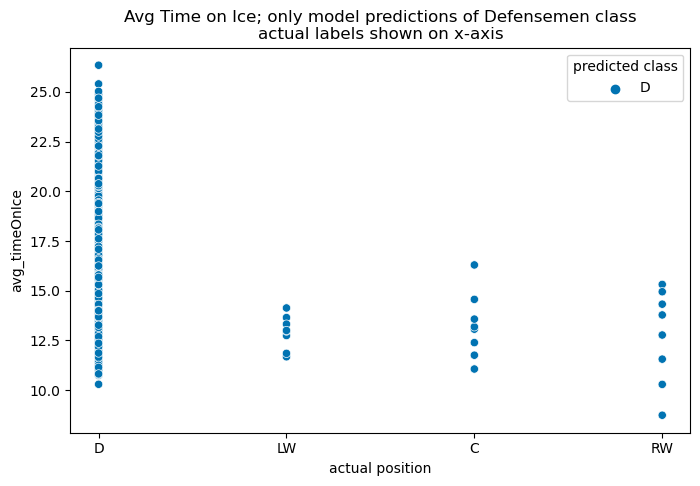

In [28]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_agg[df_agg.model_classes == "D"],
    y="avg_timeOnIce",
    x="primaryPosition",
    hue="model_classes",
    palette="colorblind"
)
plt.title("Avg Time on Ice; only model predictions of Defensemen class\nactual labels shown on x-axis")
plt.xlabel("actual position")
plt.legend(title="predicted class")
plt.show()

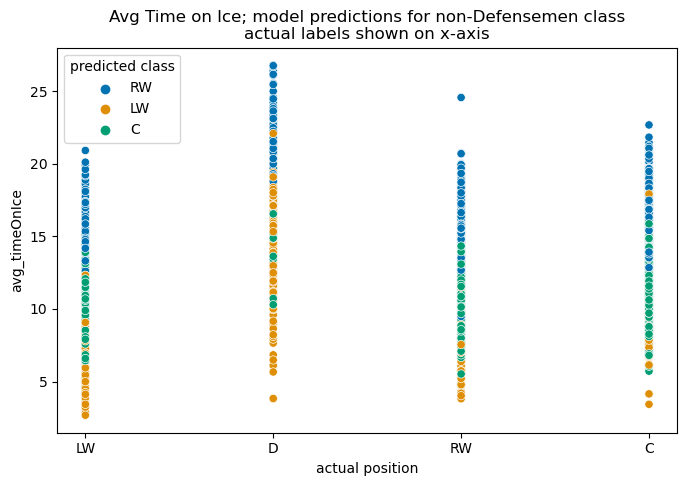

In [29]:
# non defensemen
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_agg[df_agg.model_classes != "D"],
    y="avg_timeOnIce",
    x="primaryPosition",
    hue="model_classes",
    palette="colorblind"
)
plt.title("Avg Time on Ice; model predictions for non-Defensemen class\nactual labels shown on x-axis")
plt.xlabel("actual position")
plt.legend(title="predicted class")
plt.show()

**The above plots can be supported with a confusion matrix**

In [35]:
from sklearn.metrics import confusion_matrix

In [34]:
reverse_label_mapping = {v:k for k, v in label_mapping.items()}
print(reverse_label_mapping)

df_agg["actual_position_class"] = df_agg['primaryPosition'].map(reverse_label_mapping)
df_agg[:4]


{'C': 0, 'LW': 1, 'RW': 2, 'D': 3}


,player_id,timeOnIce,assists,goals,shots,hits,penaltyMinutes,faceoffTaken,takeaways,giveaways,blocked,games_played,primaryPosition,firstName,lastName,avg_timeOnIce,avg_assists,avg_goals,avg_shots,avg_hits,avg_penaltyMinutes,avg_faceoffTaken,avg_takeaways,avg_giveaways,avg_blocked,model_preds,model_classes,actual_position_class
0,8444894,863.43,12,11,66,0.0,10,26,0.0,0.0,0.0,60,LW,Greg,Adams,14.390,0.200,0.183,1.100,0.0,0.167,0.433,0.0,0.0,0.0,2,RW,1
1,8444919,3882.17,37,4,174,0.0,38,0,0.0,0.0,0.0,236,D,Tommy,Albelin,16.450,0.157,0.017,0.737,0.0,0.161,0.000,0.0,0.0,0.0,1,LW,3
2,8445000,5367.15,74,88,696,0.0,233,4646,0.0,0.0,0.0,352,LW,Dave,Andreychuk,15.248,0.210,0.250,1.977,0.0,0.662,13.199,0.0,0.0,0.0,2,RW,1
3,8445176,3581.92,82,59,532,0.0,153,25,0.0,0.0,0.0,214,RW,Donald,Audette,16.738,0.383,0.276,2.486,0.0,0.715,0.117,0.0,0.0,0.0,2,RW,2


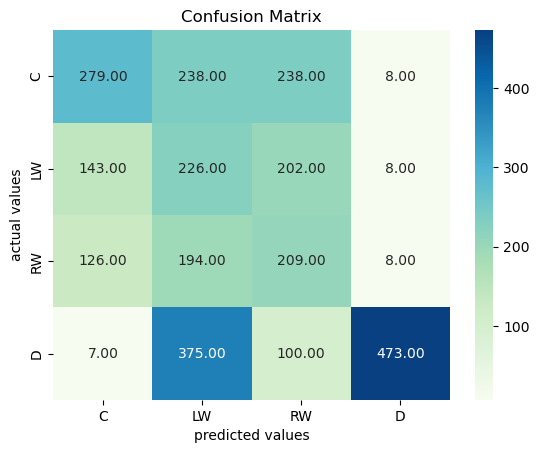

In [53]:
y_true = df_agg['actual_position_class']
y_preds = df_agg['model_preds']

plt.figure()
sns.heatmap(confusion_matrix(y_true, y_preds), annot=True, fmt=".2f", cmap="GnBu")

plt.title("Confusion Matrix")
plt.xlabel("predicted values")
# adding .5 to tick marks in order to center labels in middle of respective square
plt.xticks(ticks=[i+.5 for i in range(4)], labels=['C', 'LW', 'RW', 'D']) # got ticks from previously created label_mapping dict
plt.yticks(ticks=[i+.5 for i in range(4)], labels=['C', 'LW', 'RW', 'D']) # got ticks from previously created label_mapping dict
plt.ylabel("actual values")

plt.show()

*As you can see from the above confusion matrix, the model did a very accurate job at predicting if a player was a Defensemen or not. Out of all the times the model predicted Defensemen,the model was right 95% of the time; a 95% True Positive Rate for Defensemen class*

### Model 3: Random Forest Classifier

Because the clustering methods did not do a good job of bucketing *all* players into the correct class, I am going to build and run a Random Forest Classifier performs in comparison

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [85]:
msk = np.random.rand(len(df_agg)) < .7
train = df_agg[msk]
test = df_agg[~msk]

print(f"{len(train)} records in the training set")
print(f"{len(test)} records in the test set")

grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [3, 5, None],
    "min_samples_leaf": [1, 3, 10]
}

clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid=grid, scoring="accuracy", cv=5)
grid.fit(train[features], train[response])

results = pd.DataFrame(grid.cv_results_)

In [86]:
print("best parameters:", grid.best_params_)
print(f"highest accuracy from model with best params: {grid.best_score_:.2f}")
results.sort_values("mean_test_score", ascending=False).head()

best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}
highest accuracy from model with best params: 0.73


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,0.207507,0.006162,0.011968,0.000423,None,1,50,"{'max_depth': None, 'min_samples_leaf': 1, 'n_...",0.7700,0.7100,0.729323,0.746867,0.701754,0.731589,0.024780,1
22,0.389979,0.003476,0.019757,0.000349,None,3,100,"{'max_depth': None, 'min_samples_leaf': 3, 'n_...",0.7725,0.7175,0.739348,0.734336,0.691729,0.731083,0.026561,2
20,0.619849,0.012278,0.029355,0.000547,None,1,150,"{'max_depth': None, 'min_samples_leaf': 1, 'n_...",0.7750,0.7125,0.746867,0.721805,0.694236,0.730081,0.028150,3
19,0.412804,0.004973,0.020552,0.000492,None,1,100,"{'max_depth': None, 'min_samples_leaf': 1, 'n_...",0.7750,0.7050,0.739348,0.736842,0.691729,0.729584,0.029148,4
11,0.445096,0.005948,0.024539,0.000195,5,1,150,"{'max_depth': 5, 'min_samples_leaf': 1, 'n_est...",0.7625,0.7350,0.741855,0.734336,0.671679,0.729074,0.030455,5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


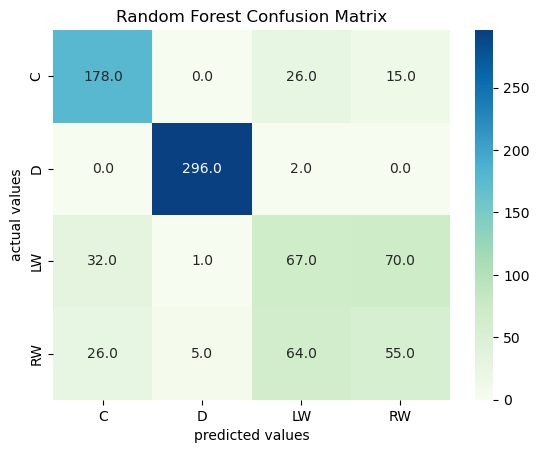

In [98]:
# confusion matrix for Random Forest Classifier
clf = RandomForestClassifier(**grid.best_params_)
clf.fit(train[features], train[response])

y_preds = clf.predict(test[features])
test['model_preds'] = y_preds
y_true = test['primaryPosition']

plt.figure()
sns.heatmap(confusion_matrix(y_true, y_preds), annot=True, fmt=".1f", cmap="GnBu")

plt.title("Random Forest Confusion Matrix")
plt.xlabel("predicted values")
# adding .5 to tick marks in order to center labels in middle of respective square
plt.xticks(ticks=[i+.5 for i in range(4)], labels=clf.classes_)
plt.yticks(ticks=[i+.5 for i in range(4)], labels=clf.classes_)
plt.ylabel("actual values")

plt.show()

As you can see from the above confusion matrix, the Random Forest model does a much better job at predicting **Defensemen** AND **Centermen** classes of players, and not just defensemen.

In [101]:
# most important features in model
df_fi = pd.DataFrame({"feature": clf.feature_names_in_, "feature_importance": clf.feature_importances_})
df_fi.sort_values("feature_importance", ascending=False)

,feature,feature_importance
6,avg_faceoffTaken,0.392037
0,avg_timeOnIce,0.119345
2,avg_goals,0.089398
9,avg_blocked,0.079503
3,avg_shots,0.068831
5,avg_penaltyMinutes,0.067064
1,avg_assists,0.064915
8,avg_giveaways,0.040974
7,avg_takeaways,0.040799
4,avg_hits,0.037134


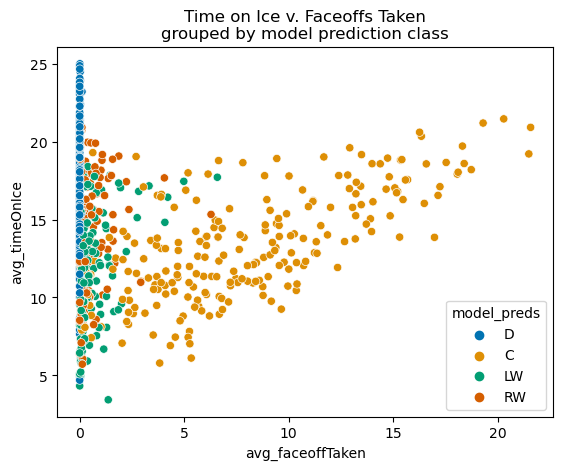

In [105]:
# scatter plot showing the top two most important features plotted with the model prediction class
plt.figure()
sns.scatterplot(test, x="avg_faceoffTaken", y="avg_timeOnIce", hue="model_preds", palette="colorblind")
plt.title("Time on Ice v. Faceoffs Taken\ngrouped by model prediction class")
plt.show()


### Conclusions


Out of all the models that were fit against the data, the Random Forest Classifier yielded the highest accuracy. The clustering methods, both KMeans and Hierarchical Clustering did a fairly poor job of assigning palyers to their proper position. My hypothesis for why the clustering models did not perform as well is because of the high dimensionality of this modeling problem. The model included 10 features in total, meaning the clustering methods mapped the data to a 10-dimensional space. This 10-dimensional space contained a lot of noise that disrupted the model from making accurate predictions. Clustering may have performed better had PCA been performed on the feature set prior to fitting the model. This would have reduced the dimensionality of the problem and caused less noise amongst the feature set. Ultimately there were two main features that the model truly learned the most amount of information on; time on ice and faceoffs taken. This is because Defensemen tend to spend the most time on ice compared to any other position (shown in the boxplots made during EDA), and Centermen take more faceoffs compared to any other position (shown in the boxplots made during EDA).

The Random Forest Classifier outperformed the clustering models, because it was able to weight these two features (by consistently choosing these features to split on) compared to the clustering model which did not weight these features at all. Additionally, neither model did a great job at making a clear distinction between Left Wingers and Right Wingers. This is because these players behave in very similar ways, and neither of these players take face offs normally (hence why the model was able to accurately predict Centermen). Had there been a feature highlighting if the player was left or right handed, perhaps that would have led to better model results (but also would have been slightly cheating as that feature would have been a clear giveaway). 


